## Figures for "A natural hazard risk modelling approach to human displacement - frontiers & challenges"

In this notebook we plot the figures shown in the manuscript titled "A natural hazard risk modelling approach to human displacement - frontiers & challenges" by Meiler et al., 2025.


Shapefiles for the counrty/admin1 borders can be accessed here: https://gadm.org/download_country.html <br>
Shapefiles for global admin0 borders can be accessed here: https://public.opendatasoft.com/explore/dataset/world-administrative-boundaries/export/ or here: https://www.naturalearthdata.com/downloads/10m-cultural-vectors/

In [1]:
# load libraries
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colorbar
from matplotlib.colors import Normalize, LogNorm
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.patches import Rectangle
from matplotlib.gridspec import GridSpec
from cartopy import crs as ccrs
import seaborn as sns
# suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# paths (to be adjusted when running on different machines)
results_path = '/Users/simonameiler/Documents/work/03_code/repos/global-displacement-risk/data/results/'
shp_path = '/Users/simonameiler/Documents/work/03_code/repos/global-displacement-risk/data/shapefiles/'
fig_save_path = '/Users/simonameiler/Documents/work/03_code/repos/global-displacement-risk/data/plots/'

# projection for plotting
robinson = ccrs.Robinson().proj4_init

### Figure 2: Global, multi-hazard, present-day displacement risk

In [3]:
def plot_global_admin1_multi_hazard(csv_files, year, scenario, metric, save=True):
    """
    Plot a global map of admin1 results using GID_1 from a GeoPackage, summing values across multiple hazards.

    Args:
    - csv_files: List of paths to the CSV files for different hazards.
    - year: Time period to filter (e.g., 2020, 2050, 2100).
    - scenario: Scenario to filter (e.g., current, optimistic, pessimistic, medium).
    - metric: Metric to plot (e.g., 'AAD', 'PMD10').
    - save: Whether to save the figure (default: True).
    """
    # Initialize an empty DataFrame to hold summed values
    combined_data = None

    # Loop through each hazard's CSV file and aggregate data
    for csv_file in csv_files:
        df = pd.read_csv(csv_file)
        df_filtered = df[(df['year'] == year) & (df['scenario'] == scenario)]
        df_filtered = df_filtered[['GID_1', metric]].copy()
        df_filtered[metric] = pd.to_numeric(df_filtered[metric], errors='coerce')

        if combined_data is None:
            combined_data = df_filtered
        else:
            combined_data = combined_data.merge(df_filtered, on='GID_1', how='outer', suffixes=('', '_other'))
            combined_data[metric] = combined_data[[metric, f'{metric}_other']].sum(axis=1, skipna=True)
            combined_data.drop(columns=[f'{metric}_other'], inplace=True)

    # Load the admin1 geometries from the GeoPackage
    admin1 = gpd.read_file(f'{shp_path}gadm_410.gpkg')
    admin1 = admin1.merge(combined_data, left_on='GID_1', right_on='GID_1', how='left')

    # Create a new column to differentiate 0 values and NaN values
    admin1['metric_category'] = admin1[metric].apply(
        lambda x: 'zero' if x == 0 else ('value' if pd.notna(x) else 'missing')
    )

    # Reproject to Robinson projection
    admin1 = admin1.to_crs(robinson)

    # Get global min/max for correct scaling
    combined_min = max(1, admin1[metric].min())  # Ensure at least 1 for LogNorm
    combined_max = admin1[metric].max()

    # Round up max to the next power of 10
    max_log = int(np.ceil(np.log10(combined_max)))  # Next full power of ten
    min_log = int(np.floor(np.log10(combined_min)))  # Lower power of ten
    combined_max = 10**max_log  # Adjust max to next power of ten

    # Define correct number of discrete colors
    num_colors = max_log - min_log  # FIX: No "+1", ensuring exact intervals
    cmap = plt.cm.get_cmap('cividis', num_colors)

    # Create figure
    fig, ax = plt.subplots(figsize=(8, 6))

    # Apply font sizes for publication
    plt.rcParams.update({
        'font.size': 10,
        'axes.titlesize': 10,
        'axes.labelsize': 10,
        'xtick.labelsize': 8,
        'ytick.labelsize': 8,
        'legend.fontsize': 8
    })

    # Plot data with correct color mapping
    admin1[admin1['metric_category'] == 'value'].plot(
        column=metric,
        ax=ax,
        legend=False,
        cmap=cmap,
        norm=LogNorm(vmin=10**min_log, vmax=combined_max),  # Correct scaling
        edgecolor='black',
        linewidth=0.001
    )

    # Plot zero values in gray
    admin1[admin1['metric_category'] == 'zero'].plot(
        color='#d6d6d6',
        ax=ax,
        edgecolor='black',
        linewidth=0.001,
        label='Value = 0'
    )

    # Plot missing values in white
    admin1[admin1['metric_category'] == 'missing'].plot(
        color='#ffffff',
        ax=ax,
        edgecolor='black',
        linewidth=0.001,
        label='No Data'
    )

    # Define colorbar ticks
    tick_values = [10**i for i in range(min_log, max_log + 1)]

    # Create a ScalarMappable for colorbar
    sm = plt.cm.ScalarMappable(
        cmap=cmap,
        norm=LogNorm(vmin=10**min_log, vmax=combined_max)
    )
    sm._A = []  # Required to associate data with ScalarMappable

    # Add colorbar
    cbar = fig.colorbar(sm, ax=ax, shrink=0.5, pad=0.02, ticks=tick_values)
    cbar.set_label(f"{metric}", fontsize=10)
    cbar.ax.tick_params(labelsize=8)

    # Set correct tick labels
    cbar.set_ticklabels([f"$10^{i}$" for i in range(min_log, max_log + 1)])

    # Remove axis
    ax.set_axis_off()

    # Save or show figure
    if save:
        save_fig_str = f'admin1_global_{year}_{scenario}_{metric}_multi_hazard.png'
        plt.savefig(
            fig_save_path + save_fig_str,
            dpi=300,
            facecolor='w',
            edgecolor='w',
            orientation='portrait',
            format='png',
            bbox_inches='tight',
            pad_inches=0.1
        )
    else:
        plt.show()

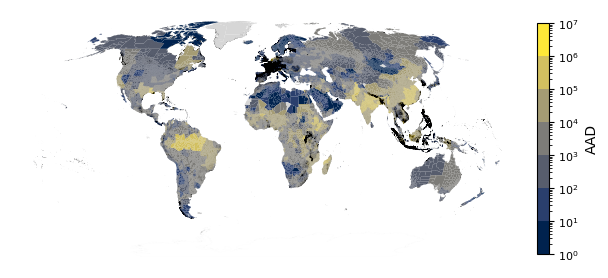

In [4]:
plot_global_admin1_multi_hazard(
    csv_files=[f'{results_path}drought_admin1.csv',
              f'{results_path}cf_admin1_0.55.csv',
              f'{results_path}FL_admin1.csv',
              f'{results_path}tc_admin1_0.55.csv'],
    year=2020,
    scenario='current',
    metric='AAD')

### Figure 3: Global present-day displacement risk from the single hazards

and Supplementary Figure 2

In [5]:
def plot_hazard_subplots(input_files, year, scenario, metric, titles, save=True):
    """
    Create a 2x2 subplot of global maps for different hazards with a shared year and scenario.
    
    Args:
    - input_files: List of 4 CSV file paths, each containing data for a different hazard.
    - year: Time period to filter (e.g., 2020, 2050, 2100) – same for all hazards.
    - scenario: Scenario to filter (e.g., 'current', 'optimistic', 'pessimistic', 'medium') – same for all hazards.
    - metric: Metric to plot (e.g., 'AAD', 'PMD10') – must be consistent across all files.
    - titles: List of 4 titles for the subplots.
    """

    # Set figure size for publication
    fig, axes = plt.subplots(2, 2, figsize=(8, 6))
    axes = axes.flatten()  # Flatten for easier indexing

    # Update font sizes for publication-ready figure
    plt.rcParams.update({
        'font.size': 10,
        'axes.titlesize': 10,
        'axes.labelsize': 10,
        'xtick.labelsize': 8,
        'ytick.labelsize': 8,
        'legend.fontsize': 8
    })

    # Initialize min/max properly
    combined_min, combined_max = None, None

    # Determine global min/max for consistent colorbar scaling
    for csv_file in input_files:
        df = pd.read_csv(csv_file)
        df_filtered = df[(df['year'] == year) & (df['scenario'] == scenario)]
        
        if metric in df_filtered.columns and not df_filtered[metric].isnull().all():
            min_val = df_filtered[metric].min()
            max_val = df_filtered[metric].max()
            
            combined_min = min(min_val, combined_min) if combined_min is not None else min_val
            combined_max = max(max_val, combined_max) if combined_max is not None else max_val

    # Handle case where no valid data was found
    if combined_min is None or combined_max is None:
        raise ValueError("No valid data found for the given metric, year, and scenario.")

    # Ensure vmin is at least 1 for LogNorm
    combined_min = max(1, combined_min)

    # Ensure vmax is rounded up to the next full power of 10
    max_log = int(np.ceil(np.log10(combined_max)))  # Round UP to full power of ten
    min_log = int(np.floor(np.log10(combined_min)))  # Round DOWN to full power of ten
    combined_max = 10**max_log  # Adjust max to the full power of ten

    # Define number of discrete colors correctly
    num_colors = max_log - min_log  # FIXED: No "+1" to match exact number of intervals
    cmap = plt.cm.get_cmap('cividis', num_colors)

    # Create LogNorm instance for color scaling
    #norm = mcolors.LogNorm(vmin=10**min_log, vmax=combined_max)
    norm = mcolors.BoundaryNorm(
    boundaries=[10**i for i in range(min_log, max_log + 1)], ncolors=num_colors
)

    # Plot each hazard map
    for i, (csv_file, title) in enumerate(zip(input_files, titles)):
        ax = axes[i]

        # Load and filter data
        df = pd.read_csv(csv_file)
        df_filtered = df[(df['year'] == year) & (df['scenario'] == scenario)]
        world = gpd.read_file(f'{shp_path}ne_50m_admin_0_countries')
        world = world[world['ISO_A3'] != 'ATA']
        world = world.merge(df_filtered, left_on='ISO_A3', right_on='admin0', how='left')
        world[metric] = pd.to_numeric(world[metric], errors='coerce')
        world['metric_category'] = world[metric].apply(lambda x: 'zero' if x == 0 else ('value' if pd.notna(x) else 'missing'))
        world = world.to_crs(robinson)

        # Plot data
        world[world['metric_category'] == 'value'].plot(
            column=metric,
            ax=ax,
            cmap=cmap,
            norm=norm,
            edgecolor='black',
            linewidth=0.1
        )
        world[world['metric_category'] == 'zero'].plot(
            color='#d6d6d6',
            ax=ax,
            edgecolor='black',
            linewidth=0.1
        )
        world[world['metric_category'] == 'missing'].plot(
            color='#ffffff',
            ax=ax,
            edgecolor='black',
            linewidth=0.1
        )

        # Add subplot label and title
        ax.text(0.1, 1.05, f"{chr(97 + i)})", transform=ax.transAxes,
                size=10, weight='bold', va='top', ha='right')
        ax.set_title(title, fontsize=10)
        ax.set_axis_off()

    # Define colorbar ticks as full powers of 10
    tick_values = [10**i for i in range(min_log, max_log + 1)]

    # Add a shared colorbar
    cbar_ax = fig.add_axes([0.15, 0.1, 0.7, 0.02])
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    cbar = fig.colorbar(sm, cax=cbar_ax, ticks=tick_values, orientation='horizontal')

    # Set colorbar labels in scientific notation
    cbar.set_ticklabels([f"$10^{i}$" for i in range(min_log, max_log + 1)])
    cbar.set_label(f"{metric}", fontsize=10)

    # Adjust the layout to reduce space between subplots
    plt.tight_layout(rect=[0, 0.1, 1, 0.95])
    plt.subplots_adjust(wspace=0.0, hspace=0.0)

    if save:
        save_fig_str = f"{metric}_{scenario}_{year}.png"
        plt.savefig(
            fig_save_path + save_fig_str,
            dpi=300,
            facecolor='w',
            edgecolor='w',
            orientation='portrait',
            format='png',
            bbox_inches='tight',
            pad_inches=0.1
        )
    else:
        plt.show()


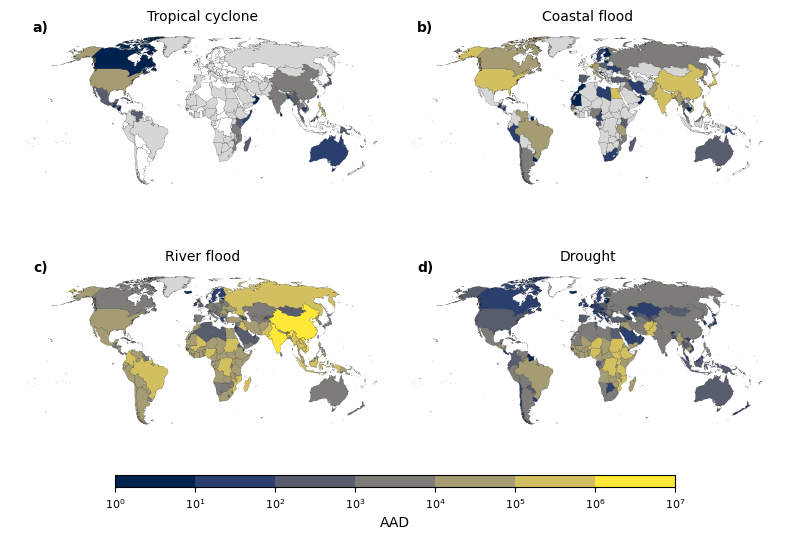

In [6]:
input_files = [f'{results_path}tc_admin0_0.55_event-based.csv', f'{results_path}cf_admin0_0.55_check.csv', f'{results_path}FL_admin0.csv', f'{results_path}drought_admin0.csv']
year = 2020
scenario = 'current'
titles = ['Tropical cyclone', 'Coastal flood', 'River flood', 'Drought']
metric = 'AAD'

plot_hazard_subplots(input_files, year, scenario, metric, titles, save=True)

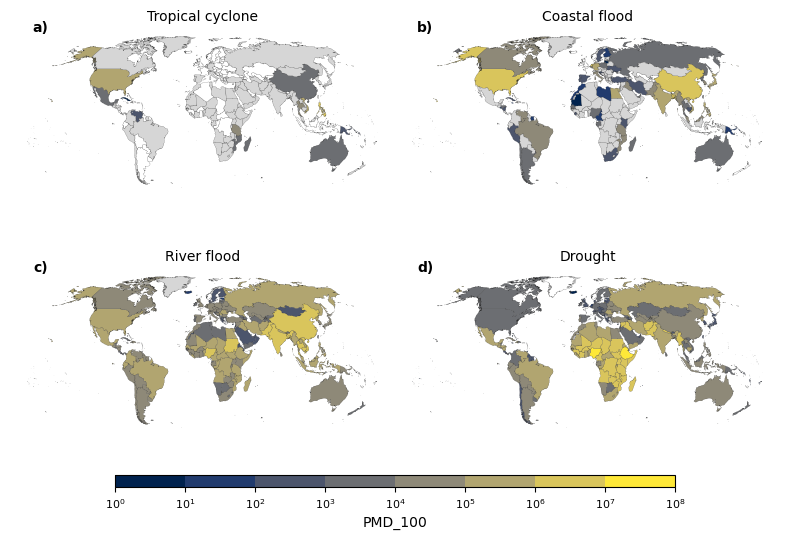

In [7]:
input_files = [f'{results_path}tc_admin0_0.55_event-based.csv', f'{results_path}cf_admin0_0.55_check.csv', f'{results_path}FL_admin0.csv', f'{results_path}drought_admin0.csv']
year = 2020
scenario = 'current'
titles = ['Tropical cyclone', 'Coastal flood', 'River flood', 'Drought']
metric = 'PMD_100'

plot_hazard_subplots(input_files, year, scenario, metric, titles, save=True)

### Supplementary Figure 1. Global per capita present-day displacement risk from the single hazards.

In [8]:
def plot_hazard_subplots_per_capita(input_files, population_files, year, scenario, metric, titles, save=True):
    """
    Create a 2x2 subplot of global maps for different hazards with results normalized by population size.
    """
    fig, axes = plt.subplots(2, 2, figsize=(8, 6))
    axes = axes.flatten()

    # Update font sizes for publication-ready figure
    plt.rcParams.update({
        'font.size': 10,
        'axes.titlesize': 10,
        'axes.labelsize': 10,
        'xtick.labelsize': 8,
        'ytick.labelsize': 8,
        'legend.fontsize': 8
    })

    # Initialize min/max values
    combined_min, combined_max = float('inf'), float('-inf')

    # Compute global min/max values across all hazards
    for csv_file, pop_file in zip(input_files, population_files):
        df = pd.read_csv(csv_file)
        pop_df = pd.read_csv(pop_file)
        df = df.merge(pop_df, on='admin0', how='left')
        df['per_capita'] = df[metric] / df['valhum']
        df_filtered = df[(df['year'] == year) & (df['scenario'] == scenario)]
        
        if 'per_capita' in df_filtered.columns:
            combined_min = min(combined_min, df_filtered['per_capita'].min())
            combined_max = max(combined_max, df_filtered['per_capita'].max())

    # Ensure min value is at least 1e-6 (avoid LogNorm errors)
    combined_min = max(1e-6, combined_min)

    # Compute bin edges based on powers of 10
    min_log = int(np.floor(np.log10(combined_min)))  # Floor to lower power of 10
    max_log = int(np.ceil(np.log10(combined_max)))  # Ceiling to next power of 10
    bin_edges = [10**i for i in range(min_log, max_log + 1)]  # Ensure binning to next larger bin

    num_colors = len(bin_edges) - 1  # Ensure exact number of discrete bins
    cmap = plt.cm.get_cmap('cividis', num_colors)

    # Define strict binning normalization
    norm = mcolors.BoundaryNorm(bin_edges, ncolors=num_colors)

    for i, (csv_file, pop_file, title) in enumerate(zip(input_files, population_files, titles)):
        ax = axes[i]
        df = pd.read_csv(csv_file)
        pop_df = pd.read_csv(pop_file)
        df = df.merge(pop_df, on='admin0', how='left')
        df['per_capita'] = df[metric] / df['valhum']
        df_filtered = df[(df['year'] == year) & (df['scenario'] == scenario)]
        world = gpd.read_file(f'{shp_path}ne_50m_admin_0_countries')
        world = world[world['ISO_A3'] != 'ATA']
        world = world.merge(df_filtered, left_on='ISO_A3', right_on='admin0', how='left')
        world['per_capita'] = pd.to_numeric(world['per_capita'], errors='coerce')
        world['metric_category'] = world['per_capita'].apply(lambda x: 'zero' if x == 0 else ('value' if pd.notna(x) else 'missing'))
        world = world.to_crs(robinson)

        world[world['metric_category'] == 'value'].plot(
            column='per_capita',
            ax=ax,
            cmap=cmap,
            norm=norm,
            edgecolor='black',
            linewidth=0.1
        )
        world[world['metric_category'] == 'zero'].plot(
            color='#d6d6d6',
            ax=ax,
            edgecolor='black',
            linewidth=0.1
        )
        world[world['metric_category'] == 'missing'].plot(
            color='#ffffff',
            ax=ax,
            edgecolor='black',
            linewidth=0.1
        )

        ax.text(0.1, 1.05, f"{chr(97 + i)})", transform=ax.transAxes,
                size=10, weight='bold', va='top', ha='right')
        ax.set_title(title, fontsize=10)
        ax.set_axis_off()

    # Define colorbar ticks as full powers of 10
    tick_values = bin_edges.copy()

    # Add a shared discrete colorbar (no truncation, just binning to the next larger bin)
    cbar_ax = fig.add_axes([0.15, 0.1, 0.7, 0.02])
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    cbar = fig.colorbar(sm, cax=cbar_ax, ticks=tick_values, orientation='horizontal')

    # Set colorbar labels in scientific notation
    cbar.set_ticklabels([f"$10^{{{i}}}$" for i in range(min_log, max_log + 1)])
    cbar.set_label(f"{metric} per capita", fontsize=10)

    plt.tight_layout(rect=[0, 0.1, 1, 0.95])
    plt.subplots_adjust(wspace=0.0, hspace=0.0)

    if save:
        save_fig_str = f"{metric}_{scenario}_{year}_per_capita.png"
        plt.savefig(
            fig_save_path + save_fig_str,
            dpi=300,
            facecolor='w',
            edgecolor='w',
            orientation='portrait',
            format='png',
            bbox_inches='tight',
            pad_inches=0.1
        )
    else:
        plt.show()

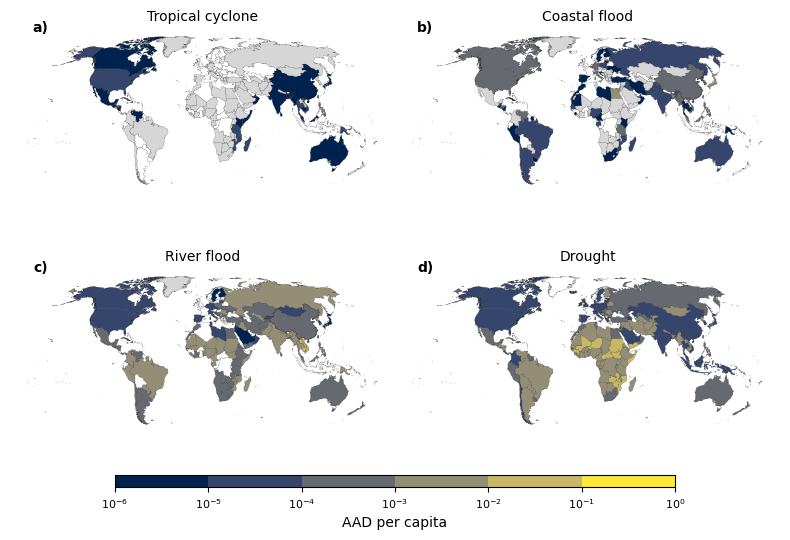

In [9]:
input_files = [f'{results_path}tc_admin0_0.55_event-based.csv', f'{results_path}cf_admin0_0.55_check.csv', f'{results_path}FL_admin0.csv', f'{results_path}drought_admin0.csv']
population_file = [f'{results_path}pop_count_admin0.csv', f'{results_path}pop_count_admin0.csv', f'{results_path}pop_count_admin0.csv', f'{results_path}pop_count_admin0_drought.csv']
year = 2020
scenario = 'current'
titles = ['Tropical cyclone', 'Coastal flood', 'River flood', 'Drought']
metric = 'AAD'

plot_hazard_subplots_per_capita(input_files, population_file, year, scenario, metric, titles, save=True)

### Figure 4. Global future displacement risk changes.

And Supplementary Figure 3, Supplementary Figure 4, Supplementary Figure 5

In [10]:
def plot_relative_changes(input_files, future_year, future_scenario, metric, titles, save=True):
    baseline_year = 2020
    baseline_scenario = 'current'

    fig, axes = plt.subplots(2, 2, figsize=(8, 6))
    axes = axes.flatten()

    plt.rcParams.update({
        'font.size': 10,
        'axes.titlesize': 10,
        'axes.labelsize': 10,
        'xtick.labelsize': 8,
        'ytick.labelsize': 8,
        'legend.fontsize': 8
    })

    # Define bin edges and colormap
    boundaries = [-10000, -1000, -100, -10, 10, 100, 1000, 10000]
    base_cmap = plt.cm.get_cmap('coolwarm', len(boundaries)-1)
    colors = list(base_cmap(np.arange(len(boundaries)-1)))
    colors[3] = '#d6d6d6'  # Bin covering -10% to 10%
    new_cmap = matplotlib.colors.ListedColormap(colors)
    norm = matplotlib.colors.BoundaryNorm(boundaries, ncolors=new_cmap.N)

    newly_affected_color = '#ffcc00'
    zero_zero_color = '#faebd7'

    for i, (csv_file, title) in enumerate(zip(input_files, titles)):
        ax = axes[i]

        df = pd.read_csv(csv_file)
        baseline_data = df[(df['year'] == baseline_year) & (df['scenario'] == baseline_scenario)]
        future_data = df[(df['year'] == future_year) & (df['scenario'] == future_scenario)]

        merged = pd.merge(
            baseline_data[['admin0', metric]],
            future_data[['admin0', metric]],
            on='admin0',
            suffixes=('_baseline', '_future')
        )

        # Compute relative change with additional zero-zero group
        merged['relative_change'] = np.select(
            [
                (merged[f'{metric}_baseline'] == 0) & (merged[f'{metric}_future'] > 0),     # Newly affected
                (merged[f'{metric}_baseline'] == 0) & (merged[f'{metric}_future'] == 0),    # Zero-zero group
                (merged[f'{metric}_baseline'] < 50) & (merged[f'{metric}_baseline'] > 0)    # Small baseline
            ],
            [
                -9999,   # Newly affected
                -9998,   # Zero in both periods
                np.nan   # Small baseline, hatch
            ],
            default=(merged[f'{metric}_future'] - merged[f'{metric}_baseline']) / merged[f'{metric}_baseline'] * 100
        )
        merged['relative_change'] = merged['relative_change'].replace([float('inf'), -float('inf')], np.nan)

        # Load and merge shapefile
        world = gpd.read_file(f'{shp_path}ne_50m_admin_0_countries')
        world = world[world['ISO_A3'] != 'ATA']
        fix_iso3 = {'Norway': 'NOR', 'France': 'FRA', 'Kosovo': 'XKO', 'Northern Cyprus': 'CYP'}
        world['ISO_A3'] = world.apply(
            lambda row: fix_iso3.get(row['NAME'], row['ISO_A3']) if row['ISO_A3'] == '-99' else row['ISO_A3'],
            axis=1
        )
        world = world.merge(merged, left_on='ISO_A3', right_on='admin0', how='left')
        world = world.to_crs(robinson)

        # Plot country boundaries
        world.boundary.plot(ax=ax, color='black', linewidth=0.1)

        # Plot newly affected areas
        world['newly_affected'] = world['relative_change'] == -9999
        world[world['newly_affected']].plot(
            ax=ax,
            color=newly_affected_color,
            edgecolor='black',
            linewidth=0.1
        )

        # Plot zero–zero areas
        world['zero_zero'] = world['relative_change'] == -9998
        world[world['zero_zero']].plot(
            ax=ax,
            color=zero_zero_color,
            edgecolor='black',
            linewidth=0.1
        )

        # Plot valid relative change
        world_valid = world[
            (~world['newly_affected']) &
            (~world['zero_zero']) &
            (world['relative_change'].notna()) &
            (world[f'{metric}_baseline'] >= 50)
        ]
        world_valid.plot(
            column='relative_change',
            ax=ax,
            cmap=new_cmap,
            norm=norm,
            edgecolor='black',
            linewidth=0.1,
            legend=False
        )

        # Plot hatched regions (baseline 1–50)
        world_hatch = world[
            (world[f'{metric}_baseline'] > 0) &
            (world[f'{metric}_baseline'] < 50)
        ]
        world_hatch.plot(
            ax=ax,
            color='none',
            edgecolor='black',
            linewidth=0.1,
            hatch='/////'
        )

        ax.text(0.1, 1.05, f"{chr(97 + i)})", transform=ax.transAxes,
                size=10, weight='bold', va='top', ha='right')
        ax.set_title(title, fontsize=10)
        ax.set_axis_off()

    # Colorbar
    cbar_ax = fig.add_axes([0.15, 0.1, 0.7, 0.02])
    sm = matplotlib.cm.ScalarMappable(cmap=new_cmap, norm=norm)
    cbar = fig.colorbar(sm, cax=cbar_ax, boundaries=boundaries, orientation='horizontal')
    cbar.set_label(f"Relative Change in {metric} by {future_year} (%)", fontsize=10)
    cbar.set_ticks(boundaries)
    cbar.set_ticklabels([
        f"$-10^{{{int(np.log10(abs(b)))}}}$" if b < 0 else (f"$10^{{{int(np.log10(b))}}}$" if b > 0 else "0")
        for b in boundaries
    ])

    # Custom legend patches
    box_size = 0.02
    box_x = 0.88

    # Newly affected
    box_y = 0.115
    ax_box = fig.add_axes([box_x, box_y, box_size, box_size])
    ax_box.add_patch(Rectangle((0, 0), 1, 1, color=newly_affected_color))
    ax_box.set_xlim(0, 1)
    ax_box.set_ylim(0, 1)
    ax_box.axis('off')
    fig.text(box_x + 0.03, box_y + 0.01, "Newly Affected Areas", fontsize=8, color='black', va='center', ha='left')

    # Hatched (baseline 1–50)
    box_y = 0.085
    ax_box = fig.add_axes([box_x, box_y, box_size, box_size])
    ax_box.add_patch(Rectangle((0, 0), 1, 1, facecolor='none', edgecolor='black', hatch='///'))
    ax_box.set_xlim(0, 1)
    ax_box.set_ylim(0, 1)
    ax_box.axis('off')
    fig.text(box_x + 0.03, box_y + 0.01, "Baseline 1–50", fontsize=8, color='black', va='center', ha='left')

    plt.tight_layout(rect=[0, 0.1, 1, 0.95])
    plt.subplots_adjust(wspace=0.0, hspace=0.0)

    if save:
        save_fig_str = f"relative_change_discrete_{metric}_{future_year}_{future_scenario}.png"
        plt.savefig(
            fig_save_path + save_fig_str,
            dpi=300,
            facecolor='w',
            edgecolor='w',
            orientation='portrait',
            format='png',
            bbox_inches='tight',
            pad_inches=0.1
        )
    else:
        plt.show()


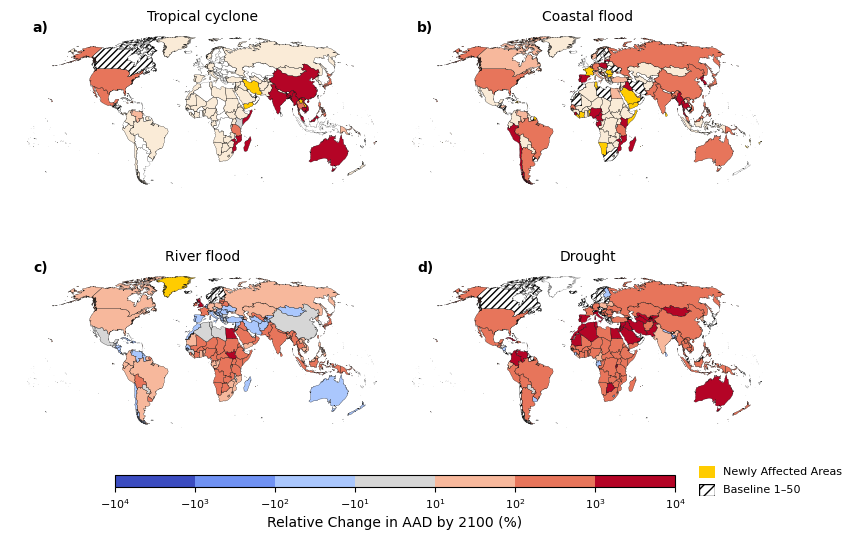

In [11]:
input_files = [f'{results_path}tc_admin0_0.55_event-based.csv', f'{results_path}cf_admin0_0.55.csv', f'{results_path}FL_admin0.csv', f'{results_path}drought_admin0.csv']
future_year = 2100
future_scenario = 'pessimistic'
metric = 'AAD'
titles = ['Tropical cyclone', 'Coastal flood', 'River flood', 'Drought']

plot_relative_changes(input_files, future_year, future_scenario, metric, titles)

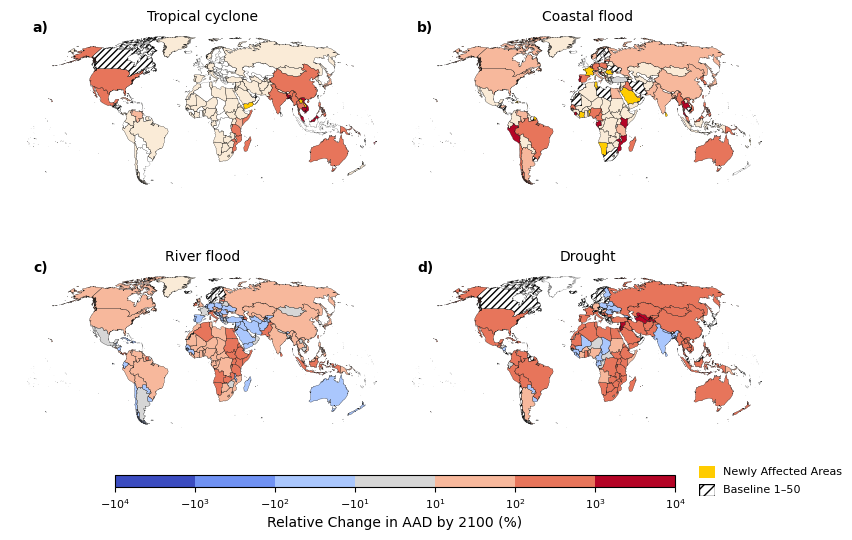

In [12]:
input_files = [f'{results_path}tc_admin0_0.55_event-based.csv', f'{results_path}cf_admin0_0.55.csv', f'{results_path}FL_admin0.csv', f'{results_path}drought_admin0.csv']
future_year = 2100
future_scenario = 'optimistic'
metric = 'AAD'
titles = ['Tropical cyclone', 'Coastal flood', 'River flood', 'Drought']

plot_relative_changes(input_files, future_year, future_scenario, metric, titles)

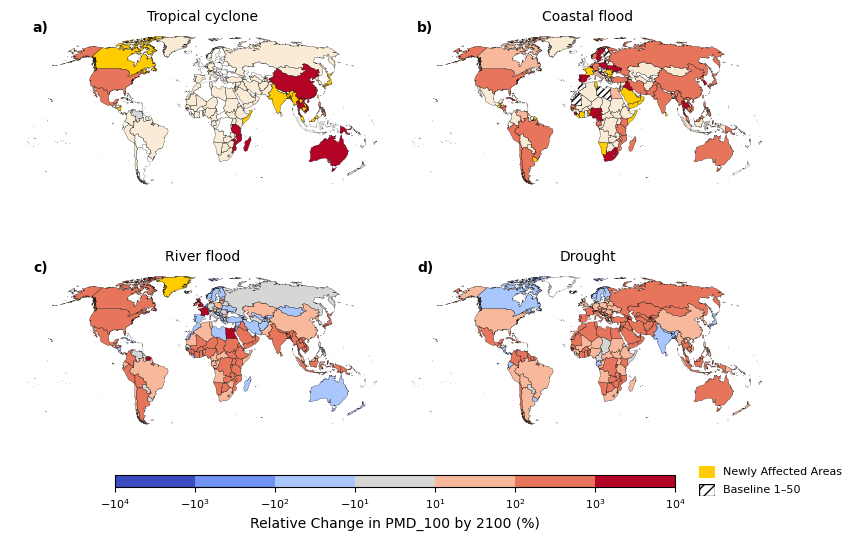

In [13]:
input_files = [f'{results_path}tc_admin0_0.55_event-based.csv', f'{results_path}cf_admin0_0.55.csv', f'{results_path}FL_admin0.csv', f'{results_path}drought_admin0.csv']
future_year = 2100
future_scenario = 'pessimistic'
metric = 'PMD_100'
titles = ['Tropical cyclone', 'Coastal flood', 'River flood', 'Drought']

plot_relative_changes(input_files, future_year, future_scenario, metric, titles)

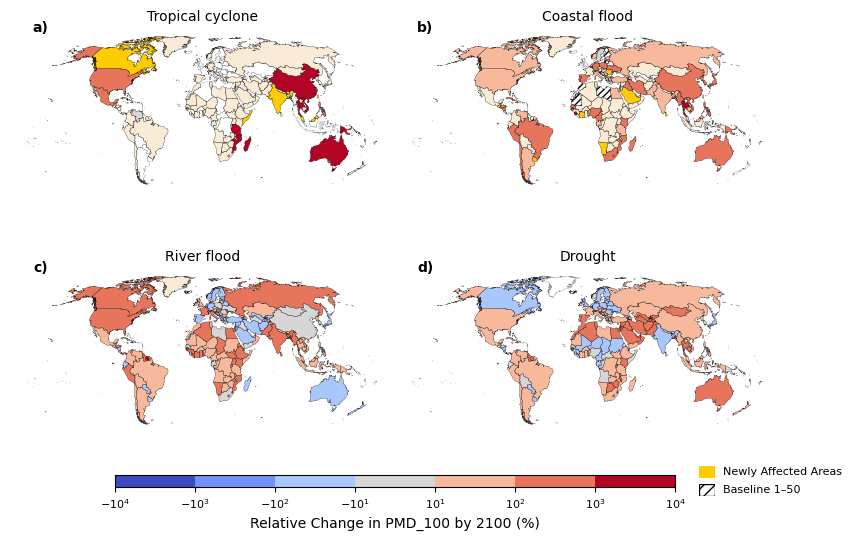

In [14]:
input_files = [f'{results_path}tc_admin0_0.55_event-based.csv', f'{results_path}cf_admin0_0.55.csv', f'{results_path}FL_admin0.csv', f'{results_path}drought_admin0.csv']
future_year = 2100
future_scenario = 'optimistic'
metric = 'PMD_100'
titles = ['Tropical cyclone', 'Coastal flood', 'River flood', 'Drought']

plot_relative_changes(input_files, future_year, future_scenario, metric, titles)

### Figure 5. Displacement from tropical cyclone winds in the Philippines

In [15]:
def admin1_subplots_tc(csv_file, country, metric, thresh, save=True):
    df = pd.read_csv(csv_file)
    df_clean = df[df['GID_1'].notna()]
    gdf = gpd.read_file(f'{shp_path}/gadm41_{country}_shp/gadm41_{country}_1.shp')
    gdf = gdf[~gdf['GID_1'].str.contains('USA.2_')]

    baseline_scenario = 'current'
    baseline_year = 'hist'
    metric_column = f'{metric}_{thresh}'

    baseline_data = df_clean[(df_clean['GID_1'].str.startswith(country)) &
                             (df_clean['scenario'] == baseline_scenario) &
                             (df_clean['time_horizon'] == baseline_year)]

    gdf_baseline = gdf.merge(baseline_data, on='GID_1', how='left')
    gdf_baseline = gdf_baseline.to_crs("ESRI:54030")

    scenarios = ['optimistic', 'pessimistic']
    years = ['2050', '2100']
    fig, axes = plt.subplots(2, 3, figsize=(8, 6), gridspec_kw={'width_ratios': [1, 1, 1], 'height_ratios': [1, 1]})
    axes = axes.flatten()

    # Present-day AAD (subplot a)
    ax_aad = axes[0]
    vmin_aad = gdf_baseline[metric_column].replace(0, np.nan).min()
    vmax_aad = gdf_baseline[metric_column].max()
    min_log_aad = 0
    max_log_aad = int(np.ceil(np.log10(vmax_aad)))
    bin_edges_aad = [10**i for i in range(min_log_aad, max_log_aad + 1)]
    num_colors_aad = len(bin_edges_aad) - 1
    cmap_aad = plt.cm.get_cmap('cividis', num_colors_aad)
    norm_aad = mcolors.BoundaryNorm(bin_edges_aad, ncolors=num_colors_aad)

    gdf_baseline.plot(column=metric_column, ax=ax_aad, cmap=cmap_aad, norm=norm_aad,
                      edgecolor='black', linewidth=0.1)
    gdf_baseline.boundary.plot(ax=ax_aad, color='black', linewidth=0.25)
    ax_aad.set_title('Present-day', fontsize=10)
    ax_aad.set_axis_off()

    cbar_ax_aad = fig.add_axes([0.33, 0.55, 0.01, 0.35])
    sm_aad = cm.ScalarMappable(cmap=cmap_aad, norm=norm_aad)
    cbar_aad = fig.colorbar(sm_aad, cax=cbar_ax_aad, orientation='vertical')
    cbar_aad.set_label(f"{metric}", fontsize=10)
    cbar_aad.set_ticks(bin_edges_aad)
    cbar_aad.set_ticklabels([f"$10^{{{i}}}$" for i in range(min_log_aad, max_log_aad + 1)])

    # Empty subplot placeholder
    axes[3].axis('off')

    # Relative change color bins
    boundaries = [-10000, -1000, -100, -10, 10, 100, 1000, 10000]
    base_cmap = plt.cm.get_cmap('coolwarm', len(boundaries) - 1)
    colors = list(base_cmap(np.arange(len(boundaries) - 1)))
    colors[3] = '#d6d6d6'  # light grey for ±10%
    cmap_relative = mcolors.ListedColormap(colors)
    norm_relative = mcolors.BoundaryNorm(boundaries, ncolors=cmap_relative.N)

    subplot_labels = ['b', 'c', 'd', 'e']
    idx_label = 0

    for row, scenario in enumerate(scenarios):
        for col, year in enumerate(years):
            idx = 1 + col + row * 3
            ax = axes[idx]

            future_data = df_clean[(df_clean['GID_1'].str.startswith(country)) &
                                   (df_clean['scenario'] == scenario) &
                                   (df_clean['time_horizon'] == year)]

            merged = pd.merge(
                baseline_data[['GID_1', metric_column]],
                future_data[['GID_1', metric_column]],
                on='GID_1',
                suffixes=('_baseline', '_future')
            )

            merged['relative_change'] = np.select(
                [
                    (merged[f'{metric_column}_baseline'] == 0) & (merged[f'{metric_column}_future'] > 0),
                    (merged[f'{metric_column}_baseline'] == 0) & (merged[f'{metric_column}_future'] == 0),
                    (merged[f'{metric_column}_baseline'] < 50) & (merged[f'{metric_column}_baseline'] > 0)
                ],
                [
                    -9999,   # newly affected
                    -9998,   # zero-zero
                    np.nan   # small baseline: hatched
                ],
                default=(merged[f'{metric_column}_future'] - merged[f'{metric_column}_baseline']) /
                        merged[f'{metric_column}_baseline'] * 100
            )
            merged['relative_change'] = merged['relative_change'].replace([np.inf, -np.inf], np.nan)

            gdf_rel = gdf.merge(merged, on='GID_1', how='left')
            gdf_rel = gdf_rel.to_crs("ESRI:54030")
            gdf_rel.boundary.plot(ax=ax, color='black', linewidth=0.25)

            # Plot categories
            gdf_rel[gdf_rel['relative_change'] == -9999].plot(ax=ax, color='#ffcc00', edgecolor='black', linewidth=0.1)
            gdf_rel[gdf_rel['relative_change'] == -9998].plot(ax=ax, color='#faebd7', edgecolor='black', linewidth=0.1)
            gdf_valid = gdf_rel[
                (gdf_rel['relative_change'].notna()) &
                (gdf_rel['relative_change'] != -9999) &
                (gdf_rel['relative_change'] != -9998) &
                (gdf_rel[f'{metric_column}_baseline'] >= 50)
            ]
            gdf_valid.plot(column='relative_change', ax=ax, cmap=cmap_relative, norm=norm_relative,
                           edgecolor='black', linewidth=0.1)
            gdf_hatch = gdf_rel[
                (gdf_rel[f'{metric_column}_baseline'] > 0) &
                (gdf_rel[f'{metric_column}_baseline'] < 50)
            ]
            gdf_hatch.plot(ax=ax, color='none', edgecolor='black', linewidth=0.1, hatch='/////')

            ax.set_title(f'{scenario.capitalize()} {year}', fontsize=10)
            ax.set_axis_off()
            ax.text(-0.12, 0.98, subplot_labels[idx_label]+')', transform=ax.transAxes, fontsize=10, weight='bold')
            idx_label += 1

    # Colorbar
    cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])
    sm = cm.ScalarMappable(cmap=cmap_relative, norm=norm_relative)
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation='vertical')
    cbar.set_label(f"Relative Change in {metric} (%)", fontsize=10)
    cbar.set_ticks(boundaries)
    cbar.set_ticklabels([f"$10^{{{int(np.log10(abs(i)))}}}$" if i != 0 else "0" for i in boundaries])

    # Custom legend patches
    legend_entries = [
        ("#ffcc00", "Newly Affected Areas"),
        ("none", "Baseline 1–50", '/////')
    ]

    for i, (color, label, *hatch) in enumerate(legend_entries):
        box_size = 0.02
        x_start = cbar_ax.get_position().x1 - 0.02
        y_start = cbar_ax.get_position().y1 + 0.04 - i * 0.025
        ax_box = fig.add_axes([x_start, y_start, box_size, box_size])
        if hatch:
            ax_box.add_patch(Rectangle((0, 0), 1, 1, facecolor='none', edgecolor='black', hatch=hatch[0]))
        else:
            ax_box.add_patch(Rectangle((0, 0), 1, 1, color=color))
        ax_box.set_xlim(0, 1)
        ax_box.set_ylim(0, 1)
        ax_box.axis('off')
        fig.text(x_start + 0.03, y_start + 0.01, label, fontsize=8, color='black', va='center', ha='left')

    if save:
        save_fig_str = f"tc_admin1_values_and_changes_{country}_{metric}_{thresh}.png"
        plt.savefig(fig_save_path + save_fig_str, dpi=300, bbox_inches='tight', pad_inches=0.1)
    else:
        plt.show()


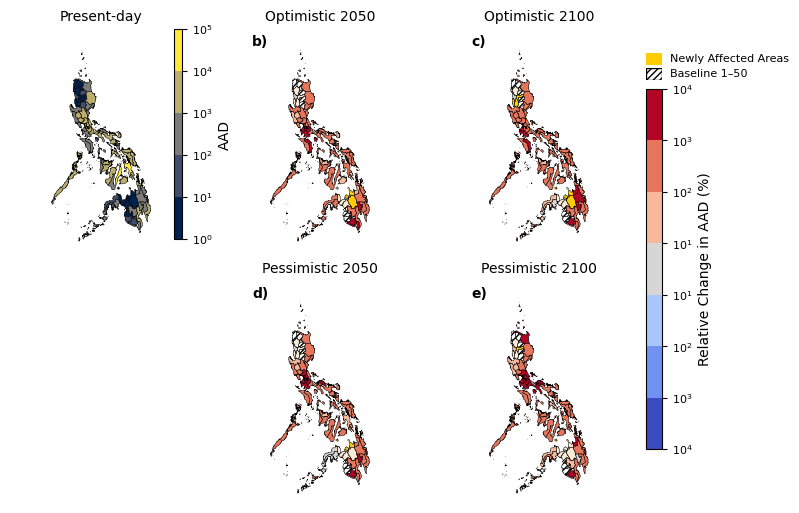

In [16]:
csv_file = f'{results_path}tc_admin1.csv'
country = 'PHL'
metric = 'AAD'
thresh = 'medium'

admin1_subplots_tc(csv_file, country, metric, thresh, save=False)

### Supplementary Figure 6. Displacement from coastal floods in the Philippines

In [17]:
def admin1_subplots_cf(csv_file, country, metric, thresh, save=True):
    df = pd.read_csv(csv_file)
    df_clean = df[df['GID_1'].notna()]
    gdf = gpd.read_file(f'{shp_path}/gadm41_{country}_shp/gadm41_{country}_1.shp')
    gdf = gdf[~gdf['GID_1'].str.contains('USA.2_')]

    baseline_scenario = 'medium'
    baseline_year = 2020
    metric_column = f'{metric}_{thresh}'

    baseline_data = df_clean[(df_clean['GID_1'].str.startswith(country)) &
                             (df_clean['scenario'] == baseline_scenario) &
                             (df_clean['time_horizon'] == baseline_year)]

    gdf_baseline = gdf.merge(baseline_data, left_on='GID_1', right_on='GID_1', how='left')
    gdf_baseline = gdf_baseline.to_crs("ESRI:54030")

    scenarios = ['optimistic', 'pessimistic']
    years = [2050, 2100]
    fig, axes = plt.subplots(2, 3, figsize=(8, 6), gridspec_kw={'width_ratios': [1, 1, 1], 'height_ratios': [1, 1]})
    axes = axes.flatten()

    ax_aad = axes[0]
    vmin_aad = gdf_baseline[metric_column].replace(0, np.nan).min()
    vmax_aad = gdf_baseline[metric_column].max()
    min_log_aad = 0
    max_log_aad = int(np.ceil(np.log10(vmax_aad)))
    bin_edges_aad = [10**i for i in range(min_log_aad, max_log_aad + 1)]
    num_colors_aad = len(bin_edges_aad) - 1
    cmap_aad = plt.cm.get_cmap('cividis', num_colors_aad)
    norm_aad = mcolors.BoundaryNorm(bin_edges_aad, ncolors=num_colors_aad)

    gdf_baseline.plot(column=metric_column, ax=ax_aad, cmap=cmap_aad, norm=norm_aad, edgecolor='black', linewidth=0.1)
    gdf_baseline.boundary.plot(ax=ax_aad, color='black', linewidth=0.25)
    ax_aad.set_title('Present-day', fontsize=10)
    ax_aad.set_axis_off()

    cbar_ax_aad = fig.add_axes([0.33, 0.55, 0.01, 0.35])
    sm_aad = cm.ScalarMappable(cmap=cmap_aad, norm=norm_aad)
    cbar_aad = fig.colorbar(sm_aad, cax=cbar_ax_aad, orientation='vertical')
    cbar_aad.set_label(f"{metric}", fontsize=10)
    cbar_aad.set_ticks(bin_edges_aad)
    cbar_aad.set_ticklabels([f"$10^{{{i}}}$" for i in range(min_log_aad, max_log_aad + 1)])

    axes[3].axis('off')

    boundaries = [-10000, -1000, -100, -10, 10, 100, 1000, 10000]
    base_cmap = plt.cm.get_cmap('coolwarm', len(boundaries) - 1)
    colors = list(base_cmap(np.arange(len(boundaries) - 1)))
    colors[3] = '#d6d6d6'
    cmap_relative = mcolors.ListedColormap(colors)
    norm_relative = mcolors.BoundaryNorm(boundaries, ncolors=cmap_relative.N)

    subplot_labels = ['b', 'c', 'd', 'e']
    idx_label = 0

    for row, scenario in enumerate(scenarios):
        for col, year in enumerate(years):
            idx = 1 + col + row * 3
            ax = axes[idx]

            future_data = df_clean[(df_clean['GID_1'].str.startswith(country)) &
                                   (df_clean['scenario'] == scenario) &
                                   (df_clean['time_horizon'] == year)]

            merged = pd.merge(
                baseline_data[['GID_1', metric_column]],
                future_data[['GID_1', metric_column]],
                on='GID_1',
                suffixes=('_baseline', '_future')
            )

            merged['relative_change'] = np.select(
                [
                    (merged[f'{metric_column}_baseline'] == 0) & (merged[f'{metric_column}_future'] > 0),
                    (merged[f'{metric_column}_baseline'] == 0) & (merged[f'{metric_column}_future'] == 0),
                    (merged[f'{metric_column}_baseline'] < 50) & (merged[f'{metric_column}_baseline'] > 0)
                ],
                [
                    -9999,
                    -9998,
                    np.nan
                ],
                default=(merged[f'{metric_column}_future'] - merged[f'{metric_column}_baseline']) /
                        merged[f'{metric_column}_baseline'] * 100
            )
            merged['relative_change'] = merged['relative_change'].replace([np.inf, -np.inf], np.nan)

            gdf_rel = gdf.merge(merged, on='GID_1', how='left')
            gdf_rel = gdf_rel.to_crs("ESRI:54030")
            gdf_rel.boundary.plot(ax=ax, color='black', linewidth=0.25)

            gdf_rel[gdf_rel['relative_change'] == -9999].plot(ax=ax, color='#ffcc00', edgecolor='black', linewidth=0.1)
            gdf_rel[gdf_rel['relative_change'] == -9998].plot(ax=ax, color='#faebd7', edgecolor='black', linewidth=0.1)
            gdf_valid = gdf_rel[
                (gdf_rel['relative_change'].notna()) &
                (gdf_rel['relative_change'] != -9999) &
                (gdf_rel['relative_change'] != -9998) &
                (gdf_rel[f'{metric_column}_baseline'] >= 50)
            ]
            gdf_valid.plot(column='relative_change', ax=ax, cmap=cmap_relative, norm=norm_relative,
                           edgecolor='black', linewidth=0.1)
            gdf_hatch = gdf_rel[
                (gdf_rel[f'{metric_column}_baseline'] > 0) &
                (gdf_rel[f'{metric_column}_baseline'] < 50)
            ]
            gdf_hatch.plot(ax=ax, color='none', edgecolor='black', linewidth=0.1, hatch='/////')

            ax.set_title(f'{scenario.capitalize()} {year}', fontsize=10)
            ax.set_axis_off()
            ax.text(-0.12, 0.98, subplot_labels[idx_label]+')', transform=ax.transAxes, fontsize=10, weight='bold')
            idx_label += 1

    # Colorbar
    cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])
    sm = cm.ScalarMappable(cmap=cmap_relative, norm=norm_relative)
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation='vertical')
    cbar.set_label(f"Relative Change in {metric} (%)", fontsize=10)
    cbar.set_ticks(boundaries)
    cbar.set_ticklabels([f"$10^{{{int(np.log10(abs(i)))}}}$" if i != 0 else "0" for i in boundaries])

    # Custom legend patches
    legend_entries = [
        ("#ffcc00", "Newly Affected Areas"),
        ("none", "Baseline 1–50", '/////')
    ]

    for i, (color, label, *hatch) in enumerate(legend_entries):
        box_size = 0.02
        x_start = cbar_ax.get_position().x1 - 0.02
        y_start = cbar_ax.get_position().y1 + 0.04 - i * 0.025
        ax_box = fig.add_axes([x_start, y_start, box_size, box_size])
        if hatch:
            ax_box.add_patch(Rectangle((0, 0), 1, 1, facecolor='none', edgecolor='black', hatch=hatch[0]))
        else:
            ax_box.add_patch(Rectangle((0, 0), 1, 1, color=color))
        ax_box.set_xlim(0, 1)
        ax_box.set_ylim(0, 1)
        ax_box.axis('off')
        fig.text(x_start + 0.03, y_start + 0.01, label, fontsize=8, color='black', va='center', ha='left')

    if save:
        save_fig_str = f"cf_admin1_values_and_changes_{country}_{metric}_{thresh}.png"
        plt.savefig(fig_save_path + save_fig_str, dpi=300, bbox_inches='tight', pad_inches=0.1)
    else:
        plt.show()

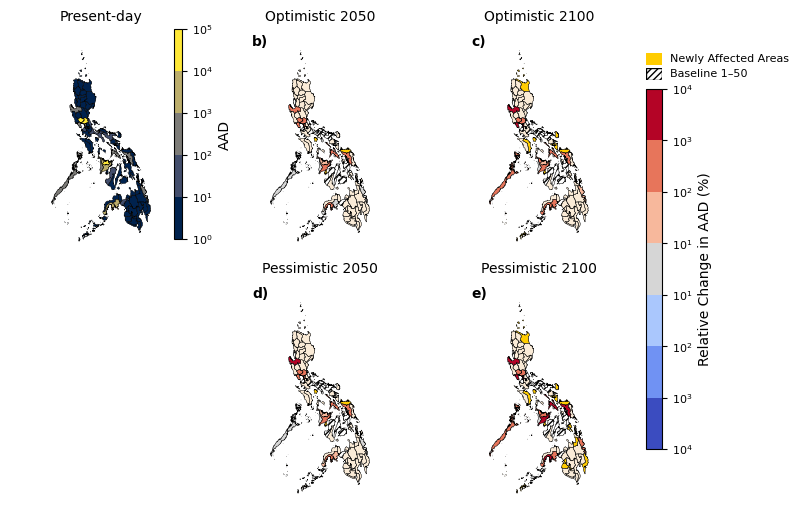

In [18]:
csv_file = f'{results_path}displacement_risk_cf_global_admin1_consolidated.csv'
country = 'PHL'
metric = 'AAD'
thresh = 'medium'

admin1_subplots_cf(csv_file, country, metric, thresh, save=True)

### Figure 6. Displacement from river flood and drought in Afghanistan.

In [19]:
def admin1_subplots_two_hazards(csv_file_hazard1, csv_file_hazard2, country, metric, hazard1, hazard2, save=True):

    df_hazard1 = pd.read_csv(csv_file_hazard1)
    df_hazard2 = pd.read_csv(csv_file_hazard2)
    df_hazard1 = df_hazard1[df_hazard1['GID_1'].notna()]
    df_hazard2 = df_hazard2[df_hazard2['GID_1'].notna()]
    gdf = gpd.read_file(f'{shp_path}/gadm41_{country}_shp/gadm41_{country}_1.shp')
    gdf = gdf[~gdf['GID_1'].str.contains(f'{country}.2_')]

    baseline_scenario = 'current'
    baseline_year = 2020
    scenarios = ['optimistic', 'pessimistic']
    year = 2100

    boundaries = [-10000, -1000, -100, -10, 10, 100, 1000, 10000]
    base_cmap = plt.cm.get_cmap('coolwarm', len(boundaries)-1)
    colors = list(base_cmap(np.arange(len(boundaries)-1)))
    colors[3] = '#d6d6d6'
    cmap_relative = mcolors.ListedColormap(colors)
    norm_relative = mcolors.BoundaryNorm(boundaries, ncolors=cmap_relative.N)

    fig = plt.figure(figsize=(8, 6))
    gs = GridSpec(2, 3, width_ratios=[1, 1, 1], height_ratios=[1, 1], wspace=0.1, hspace=0.1)
    axes = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[0, 2]),
            fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1]), fig.add_subplot(gs[1, 2])]

    for ax in [axes[1], axes[2], axes[4], axes[5]]:
        pos = ax.get_position()
        ax.set_position([pos.x0 + 0.08, pos.y0, pos.width, pos.height])

    for ax in [axes[1], axes[4]]:
        ax.axis("off")

    subplot_labels = [f"{chr(97 + i)})" for i in range(len(axes))]
    hazards = [(hazard1, df_hazard1), (hazard2, df_hazard2)]

    for row, (hazard, df_hazard) in enumerate(hazards):
        ax_present = axes[row * 3]
        ax_present.text(0.1, 1.05, subplot_labels[row * 3], transform=ax_present.transAxes, size=10, weight='bold', va='top', ha='right')

        baseline_data = df_hazard[(df_hazard['scenario'] == baseline_scenario) &
                                  (df_hazard['year'] == baseline_year) &
                                  (df_hazard['GID_1'].str.startswith(country))]
        gdf_baseline = gdf.merge(baseline_data, on='GID_1', how='left')
        gdf_baseline = gdf_baseline.to_crs("ESRI:54030")

        vmin_aad = gdf_baseline[metric].replace(0, np.nan).min()
        vmax_aad = gdf_baseline[metric].max()
        min_log_aad = 0
        max_log_aad = int(np.ceil(np.log10(vmax_aad)))
        bin_edges_aad = [10**i for i in range(min_log_aad, max_log_aad + 1)]
        num_colors_aad = len(bin_edges_aad) - 1
        norm_aad = mcolors.BoundaryNorm(bin_edges_aad, ncolors=num_colors_aad)
        cmap = plt.cm.get_cmap('cividis', num_colors_aad)
        sm_aad = cm.ScalarMappable(cmap=cmap, norm=norm_aad)

        gdf_baseline.plot(column=metric, ax=ax_present, cmap=cmap, norm=norm_aad, edgecolor='black', linewidth=0.1, legend=False)
        gdf_baseline.boundary.plot(ax=ax_present, color='black', linewidth=0.25)
        ax_present.set_axis_off()

        for col, scenario in enumerate(scenarios):
            ax_future = axes[row * 3 + col + 1]
            ax_future.text(0.1, 1.05, subplot_labels[row * 3 + col + 1], transform=ax_future.transAxes, size=10, weight='bold', va='top', ha='right')

            future_data = df_hazard[(df_hazard['scenario'] == scenario) &
                                    (df_hazard['year'] == year) &
                                    (df_hazard['GID_1'].str.startswith(country))]
            merged = pd.merge(baseline_data[['GID_1', metric]], future_data[['GID_1', metric]], on='GID_1', suffixes=('_baseline', '_future'))

            merged['relative_change'] = np.select(
                [
                    (merged[f'{metric}_baseline'] == 0) & (merged[f'{metric}_future'] > 0),
                    (merged[f'{metric}_baseline'] == 0) & (merged[f'{metric}_future'] == 0),
                    (merged[f'{metric}_baseline'] < 50) & (merged[f'{metric}_baseline'] > 0)
                ],
                [
                    -9999,
                    -9998,
                    np.nan
                ],
                default=(merged[f'{metric}_future'] - merged[f'{metric}_baseline']) / merged[f'{metric}_baseline'] * 100
            )
            merged['relative_change'] = merged['relative_change'].replace([float('inf'), -float('inf')], np.nan)

            gdf_relative = gdf.merge(merged, on='GID_1', how='left')
            gdf_relative = gdf_relative.to_crs("ESRI:54030")

            gdf_relative[gdf_relative['relative_change'] == -9999].plot(ax=ax_future, color='#ffcc00', edgecolor='black', linewidth=0.1)
            gdf_relative[gdf_relative['relative_change'] == -9998].plot(ax=ax_future, color='#faebd7', edgecolor='black', linewidth=0.1)

            gdf_valid = gdf_relative[
                (gdf_relative['relative_change'].notna()) &
                (gdf_relative['relative_change'] != -9999) &
                (gdf_relative['relative_change'] != -9998) &
                (gdf_relative[f'{metric}_baseline'] >= 50)
            ]
            gdf_valid.plot(column='relative_change', ax=ax_future, cmap=cmap_relative, norm=norm_relative, edgecolor='black', linewidth=0.1)

            gdf_hatch = gdf_relative[
                (gdf_relative[f'{metric}_baseline'] > 0) &
                (gdf_relative[f'{metric}_baseline'] < 50)
            ]
            gdf_hatch.plot(ax=ax_future, color='none', edgecolor='black', linewidth=0.1, hatch='/////')

            gdf_relative.boundary.plot(ax=ax_future, color='black', linewidth=0.25)
            ax_future.set_axis_off()

    fig.text(0.23, 0.88, 'Present-day', fontsize=10, weight='normal', ha='center')
    fig.text(0.58, 0.88, 'Optimistic 2100', fontsize=10, weight='normal', ha='center')
    fig.text(0.85, 0.88, 'Pessimistic 2100', fontsize=10, weight='normal', ha='center')
    fig.text(0.07, 0.7, 'River Flood', fontsize=10, weight='normal', rotation=90, va='center')
    fig.text(0.07, 0.3, 'Drought', fontsize=10, weight='normal', rotation=90, va='center')

    cbar_ax_aad = fig.add_axes([0.37, 0.2, 0.015, 0.6])
    cbar_aad = fig.colorbar(sm_aad, cax=cbar_ax_aad, orientation='vertical')
    cbar_aad.set_label(f"{metric}", fontsize=10)
    cbar_aad.set_ticklabels([f"$10^{{{i}}}$" for i in range(min_log_aad, max_log_aad + 1)])

    # Colorbar
    cbar_ax = fig.add_axes([0.99, 0.2, 0.015, 0.6])  # Adjust position for vertical shared colorbar
    sm = cm.ScalarMappable(cmap=cmap_relative, norm=norm_relative)
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation='vertical')
    cbar.set_label(f"Relative Change in {metric} (%)", fontsize=10)
    cbar.set_ticks(boundaries)
    cbar.set_ticklabels([f"$10^{{{int(np.log10(abs(i)))}}}$" if i != 0 else "0" for i in boundaries])

    # Custom legend patches
    legend_entries = [
        ("none", "Baseline 1–50", '/////')
    ]

    for i, (color, label, *hatch) in enumerate(legend_entries):
        box_size = 0.015
        x_start = cbar_ax.get_position().x1 - 0.015
        y_start = cbar_ax.get_position().y1 + 0.015 - i * 0.025
        ax_box = fig.add_axes([x_start, y_start, box_size, box_size])
        if hatch:
            ax_box.add_patch(Rectangle((0, 0), 1, 1, facecolor='none', edgecolor='black', hatch=hatch[0]))
        else:
            ax_box.add_patch(Rectangle((0, 0), 1, 1, color=color))
        ax_box.set_xlim(0, 1)
        ax_box.set_ylim(0, 1)
        ax_box.axis('off')
        fig.text(x_start + 0.03, y_start + 0.01, label, fontsize=8, color='black', va='center', ha='left')

    if save:
        save_fig_str = f"admin1_{hazard1}_{hazard2}_values_and_changes_{country}_{metric}.png"
        plt.savefig(fig_save_path + save_fig_str, dpi=300, bbox_inches='tight', pad_inches=0.1)
    else:
        plt.show()


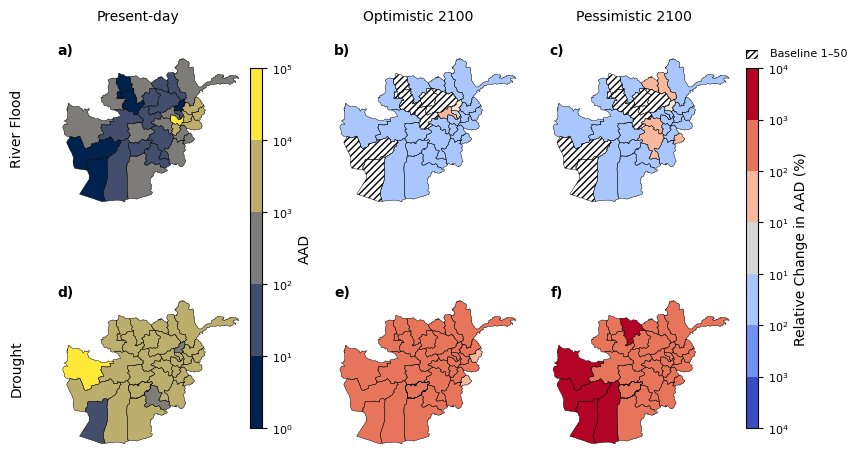

In [20]:
csv_file_hazard1 = f'{results_path}FL_admin1.csv' 
csv_file_hazard2 = f'{results_path}drought_admin1.csv'
country = 'AFG'
metric = 'AAD'
hazard1 = 'river flood'
hazard2 = 'drought'

admin1_subplots_two_hazards(csv_file_hazard1, csv_file_hazard2, country, metric, hazard1, hazard2, save=True)

### Figure 7. Displacement values derived from different building damage thresholds.

And Supplementary Figure 6, Supplementary Figure 7

In [21]:
def plot_hazard_thresholds(csv_files, country, metric, thresholds, save=True):
    """
    Create a 2-row, 3-column subplot showing admin1 regional values for two hazards and different thresholds.

    Args:
    - csv_files: List of paths to CSV files [hazard_1_file, hazard_2_file].
    - country: 3-digit ISO country code (e.g., 'USA').
    - metric: Metric type ['AAD', 'PMD_10', 'PMD_25', 'PMD_50', 'PMD_100', 'PMD_250'].
    - thresholds: Single list of thresholds corresponding to the layout.
                  Example: ['high', 'medium', 'low', 'low', 'medium', 'high'].
    - save: Boolean indicating whether to save the figure.

    Returns:
    - A figure with subplots showing the admin1 regional values for each hazard and threshold.
    """
    # Threshold-to-percentage mappings for each hazard
    threshold_to_damage = [
        {'low': 30, 'medium': 55, 'high': 70},  # First hazard (tropical cyclones)
        {'low': 30, 'medium': 55, 'high': 70}   # Second hazard (coastal floods)
    ]
    
    # Load shapefile
    gdf = gpd.read_file(f'{shp_path}/gadm41_{country}_shp/gadm41_{country}_1.shp')
    gdf = gdf[~gdf['GID_1'].str.contains('USA.2_')]
    gdf = gdf.to_crs(robinson)

    # Determine global min and max values for the colorbar
    global_min, global_max = float('inf'), float('-inf')
    for i, csv_file in enumerate(csv_files):
        df = pd.read_csv(csv_file)
        df_clean = df[df['GID_1'].notna()]
        year = 'hist' if i == 0 else 2020
        scenario = 'current' if i == 0 else 'medium'
        for thresh in ['low', 'medium', 'high']:
            metric_column = f'{metric}_{thresh}'
            df_filtered = df_clean[(df_clean['GID_1'].str.startswith(country)) & 
                                   (df_clean['scenario'] == scenario) & 
                                   (df_clean['time_horizon'] == year)]
            if metric_column in df_filtered.columns:
                global_min = min(global_min, df_filtered[metric_column].min())
                global_max = max(global_max, df_filtered[metric_column].max())

    # **Discrete Colorbar Setup**
    min_log = 0  # Always start at 10^0
    max_log = int(np.ceil(np.log10(global_max)))  # Determine the highest power of ten
    bin_edges = [10**i for i in range(min_log, max_log + 1)]
    num_colors = len(bin_edges) - 1
    cmap = plt.cm.get_cmap('cividis', num_colors)
    norm = mcolors.BoundaryNorm(bin_edges, ncolors=num_colors)

    # Create a figure and axes
    fig, axes = plt.subplots(2, 3, figsize=(8, 6), gridspec_kw={'width_ratios': [1, 1, 1], 'height_ratios': [1, 1]})
    axes = np.reshape(axes, (2, 3))  # Ensure axes is a 2D array

    # Initialize subplot labels
    subplot_labels = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)']

    # Plot for each threshold
    idx_label = 0
    for idx, thresh in enumerate(thresholds):  # Iterate over all thresholds
        row = idx // 3  # Determine row (0 or 1)
        col = idx % 3   # Determine column (0, 1, or 2)
        ax = axes[row, col]

        # Determine the appropriate hazard and file
        csv_file = csv_files[row]
        df = pd.read_csv(csv_file)
        df_clean = df[df['GID_1'].notna()]
        year = 'hist' if row == 0 else 2020
        scenario = 'current' if row == 0 else 'medium'

        # Filter data based on input criteria
        df_filtered = df_clean[(df_clean['GID_1'].str.startswith(country)) & 
                               (df_clean['scenario'] == scenario) & 
                               (df_clean['time_horizon'] == year)]

        # Create the column name based on metric and threshold
        metric_column = f'{metric}_{thresh}'
        
        # Check if the metric column exists in the data
        if metric_column not in df_filtered.columns:
            print(f"Warning: {metric_column} not found in data for {scenario} {year}. Skipping.")
            continue
        
        # Merge shapefile with data
        gdf_merged = gdf.merge(df_filtered, left_on='GID_1', right_on='GID_1', how='left')

        # Plot the data
        gdf_merged.boundary.plot(ax=ax, color='black', linewidth=0.5)  # Borders
        gdf_merged.plot(column=metric_column, ax=ax, cmap=cmap, norm=norm, 
                        edgecolor='black', linewidth=0.1, legend=False)

        # Add title with percentage of structural damage
        damage = threshold_to_damage[row][thresh]
        ax.set_axis_off()

        # Add subplot label
        ax.text(-0.15, 0.95, subplot_labels[idx_label], transform=ax.transAxes, fontsize=10, weight='bold')
        idx_label += 1

    # **Add shared discrete colorbar**
    cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])  # Adjust colorbar position
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation='vertical')
    cbar.set_label(f"{metric}", fontsize=10)
    cbar.set_ticks(bin_edges)
    cbar.set_ticklabels([f"$10^{{{i}}}$" for i in range(min_log, max_log + 1)])

    # Add shared column titles
    fig.text(0.2, 1.0, '30% Structural Damage', fontsize=10, weight='normal', ha='center')
    fig.text(0.5, 1.0, '55% Structural Damage', fontsize=10, weight='normal', ha='center')
    fig.text(0.8, 1.0, '70% Structural Damage', fontsize=10, weight='normal', ha='center')

    # Add shared row labels
    fig.text(0.02, 0.75, 'Tropical Cyclone', fontsize=10, weight='normal', rotation=90, va='center')
    fig.text(0.02, 0.25, 'Coastal Flood', fontsize=10, weight='normal', rotation=90, va='center')

    # Adjust layout
    fig.tight_layout()

    # Save or show the plot
    if save:
        save_fig_str = f"hazard_thresholds_{country}_{metric}.png"
        plt.savefig(
            fig_save_path + save_fig_str,
            dpi=300,
            facecolor='w',
            edgecolor='w',
            orientation='portrait',
            format='png',
            bbox_inches='tight',
            pad_inches=0.1
        )
    else:
        plt.show()


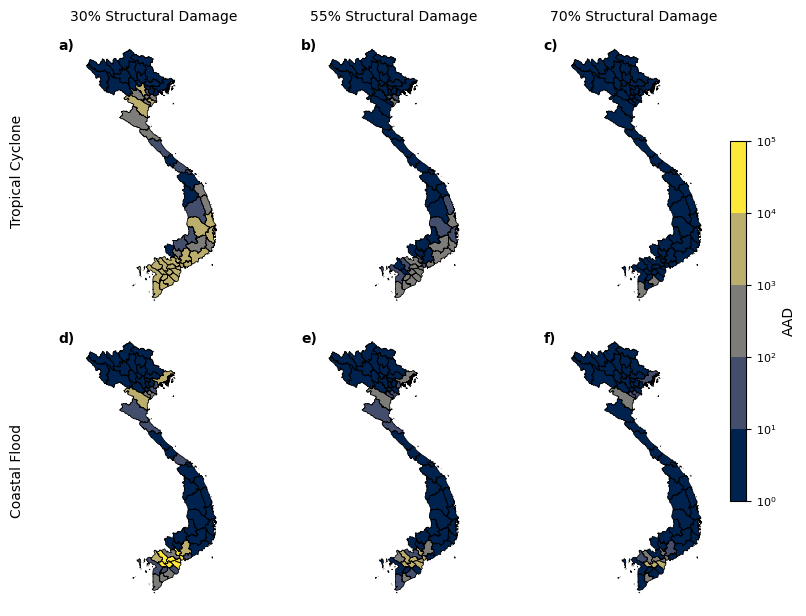

In [22]:
csv_files = [
    f'{results_path}tc_admin1.csv',  # First hazard
    f'{results_path}displacement_risk_cf_global_admin1_consolidated.csv'   # Coastal flood hazard
]
country = 'VNM'
metric = 'AAD'
thresholds = ['low', 'medium', 'high', 'low', 'medium', 'high']

plot_hazard_thresholds(csv_files, country, metric, thresholds, save=True)


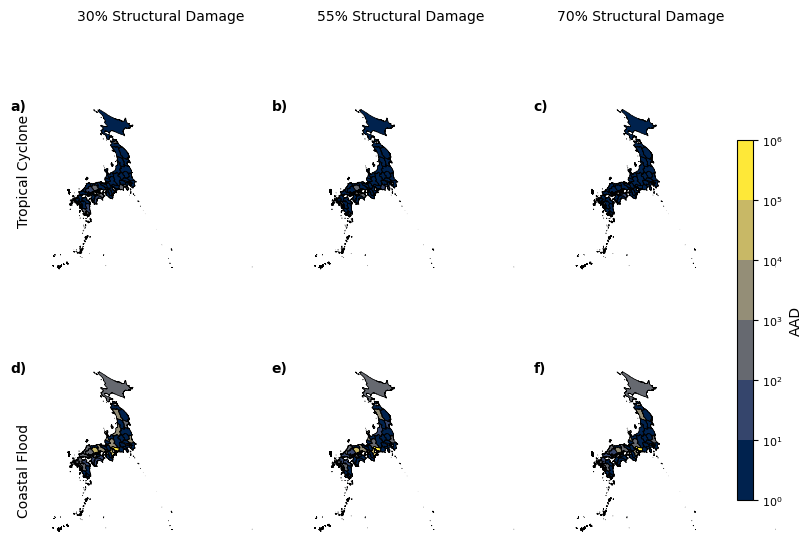

In [23]:
csv_files = [
    f'{results_path}tc_admin1.csv',  # First hazard
    f'{results_path}displacement_risk_cf_global_admin1_consolidated.csv'   # Coastal flood hazard
]
country = 'JPN'
metric = 'AAD'
thresholds = ['low', 'medium', 'high', 'low', 'medium', 'high']

plot_hazard_thresholds(csv_files, country, metric, thresholds, save=True)


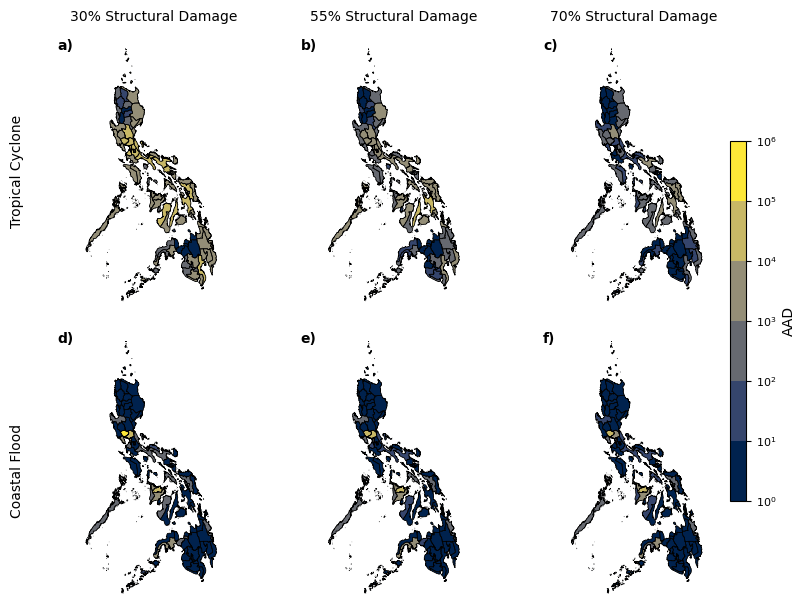

In [24]:
csv_files = [
    f'{results_path}tc_admin1.csv',  # First hazard
    f'{results_path}displacement_risk_cf_global_admin1_consolidated.csv'   # Coastal flood hazard
]
country = 'PHL'
metric = 'AAD'
thresholds = ['low', 'medium', 'high', 'low', 'medium', 'high']

plot_hazard_thresholds(csv_files, country, metric, thresholds, save=True)
